## we keep the markov matrix and lambda in EXP8, but we train the model from right the beginning. We feed it with really dense input, with 249 or 250 products

In [10]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

start_time = time.time()

N_prod = 250        # number of products
Vec_Len = N_prod + 1
Neck_Len = 30       # bottle neck width
EPOCHS = 10000
SAMPLE_AMOUNT = 5000
BATCH_SIZE = 500
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.0005

# generate latent parameters
transP = np.load("EXP8_dump/markov_matrix.npy")
lams = np.load("EXP8_dump/arriving_lambda.npy")

model = Models.Bottleneck(Vec_Len, Neck_Len)

# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    idx = np.random.uniform(low = 0,high = 1)
    if idx > 0.9:
        assort = assort = AG.GenAssortment_Fixed(N_prod,N_prod)
    else:
        assort = AG.GenAssortment_Fixed(N_prod,N_prod-1)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)

print("data generated!")
print("total time elapse : ",time.time()-start_time)

train_dataset = TensorDataset(torch.Tensor(INPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]),torch.Tensor(OUTPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]))    
vali_dataset = TensorDataset(torch.Tensor(INPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]),torch.Tensor(OUTPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]))    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
vali_loader = DataLoader(vali_dataset, shuffle=True, batch_size = len(vali_dataset))

optimizer = optim.Adam(model.parameters(), lr = ADAM_LR)
criterion = nn.BCELoss()

training_losses = np.array([])
vali_losses = np.array([])

for epo in range(1,EPOCHS+1):
    if epo % 50 == 0:
        print("epoch : ",epo)
        print(time.time()-start_time)
    
    for step, (IN, TEST) in enumerate(train_loader):
        
        OUT = model(IN)
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_pure = loss.detach().item()
        loss_base = criterion(TEST,TEST).detach().item()
        training_losses= np.append(training_losses,(loss_pure - loss_base)/loss_base)
        
    for step, (VALI_IN, VALI_TEST) in enumerate(vali_loader):
        VALI_OUT = model(VALI_IN)
        
        RELATIVE_LOSS = nn.functional.l1_loss(VALI_TEST, VALI_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(VALI_TEST, min = 1/Vec_Len)

        losses = np.mean(torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=4).detach().numpy())
        
        vali_losses = np.append(vali_losses,losses)

np.save('EXP9_dump/bottleneck_train_loss_Dense', training_losses)
np.save('EXP9_dump/bottleneck_vali_loss_Dense', vali_losses)
torch.save(model, "EXP9_dump/bottleneck_model_Dense.pth")

data generated!
total time elapse :  1.703284502029419
epoch :  50
5.88183331489563
epoch :  100
9.965369701385498
epoch :  150
13.963444709777832
epoch :  200
17.933692455291748
epoch :  250
22.014508962631226
epoch :  300
26.08984112739563
epoch :  350
30.091506958007812
epoch :  400
34.02561593055725
epoch :  450
38.002702951431274
epoch :  500
42.09046721458435
epoch :  550
46.43035650253296
epoch :  600
50.70037269592285
epoch :  650
54.83238220214844
epoch :  700
59.06674909591675
epoch :  750
63.10049915313721
epoch :  800
67.35849165916443
epoch :  850
71.35987949371338
epoch :  900
75.49008846282959
epoch :  950
79.58357524871826
epoch :  1000
83.63299107551575
epoch :  1050
87.70808148384094
epoch :  1100
91.89105105400085
epoch :  1150
95.8039186000824
epoch :  1200
99.92000579833984
epoch :  1250
104.07647943496704
epoch :  1300
108.2879843711853
epoch :  1350
112.32809686660767
epoch :  1400
116.44580578804016
epoch :  1450
120.38274383544922
epoch :  1500
124.515131950378

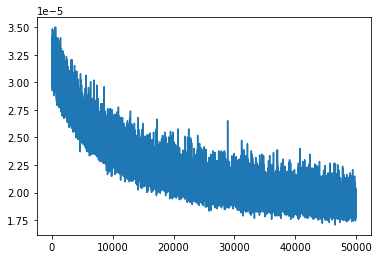

In [12]:
train_loss = np.load('EXP9_dump/bottleneck_train_loss_Dense.npy')
plt.plot(train_loss[40000:])

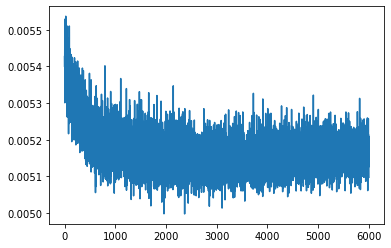

In [14]:
train_loss = np.load('EXP9_dump/bottleneck_vali_loss_Dense.npy')
plt.plot(train_loss[4000:])

## test sparse

D:\SOFTWARE\ANACONDA\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(array([4.68296e+05, 0.00000e+00, 0.00000e+00, 1.00000e+01, 1.63000e+02,
        1.46900e+03, 5.85400e+03, 8.82700e+03, 8.57800e+03, 8.80300e+03]),
 array([1.9267354e-05, 1.0001734e-01, 2.0001541e-01, 3.0001348e-01,
        4.0001157e-01, 5.0000966e-01, 6.0000771e-01, 7.0000577e-01,
        8.0000383e-01, 9.0000194e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

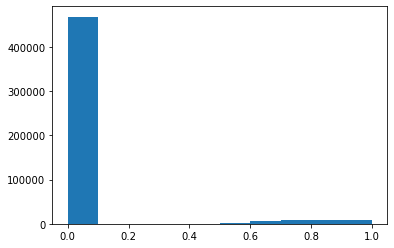

In [15]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

N_prod = 250        # number of products
Vec_Len = N_prod + 1

DENSE_AMOUNT = 2000

model = torch.load("EXP9_dump/bottleneck_model_Dense.pth")
INPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
for i in range(DENSE_AMOUNT):
    assort = AG.GenAssortment_Sparse(N_prod)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=2).detach().numpy()

plt.hist(losses)

## test 3/4 dense

(array([3.42942e+05, 1.25063e+05, 2.85920e+04, 3.36000e+03, 2.03600e+03,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 5.00000e+00]),
 array([1.2734097e-07, 2.0000011e-01, 4.0000010e-01, 6.0000008e-01,
        8.0000007e-01, 1.0000001e+00, 1.2000000e+00, 1.4000001e+00,
        1.6000000e+00, 1.8000001e+00, 2.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

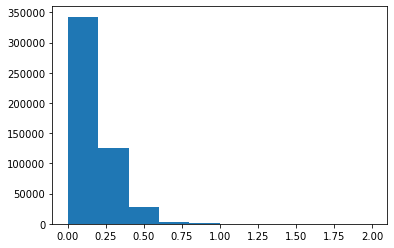

In [16]:
N_prod = 250        # number of products
Vec_Len = N_prod + 1

DENSE_AMOUNT = 2000

model = torch.load("EXP9_dump/bottleneck_model_Dense.pth")
INPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
for i in range(DENSE_AMOUNT):
    assort = AG.GenAssortment_Even(N_prod, 3/4)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=2).detach().numpy()

plt.hist(losses)

## dense

(array([5.01402e+05, 3.76000e+02, 1.71000e+02, 3.00000e+01, 1.50000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 6.00000e+00]),
 array([6.5699830e-08, 1.4204916e-01, 2.8409824e-01, 4.2614734e-01,
        5.6819642e-01, 7.1024555e-01, 8.5229462e-01, 9.9434370e-01,
        1.1363928e+00, 1.2784419e+00, 1.4204910e+00], dtype=float32),
 <BarContainer object of 10 artists>)

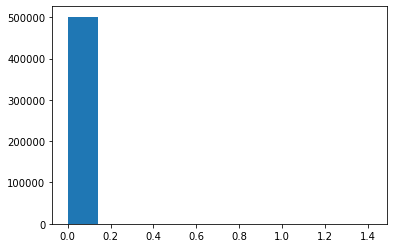

In [17]:
DENSE_AMOUNT = 2000


INPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
for i in range(DENSE_AMOUNT):
    assort = AG.GenAssortment_Fixed(N_prod, fixed_num = N_prod-1)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=2).detach().numpy()

plt.hist(losses)